In [1]:
import numpy as np
import math
from sys import getsizeof

from sklearn.linear_model import Lasso

import matplotlib.pyplot as plt

In [2]:
def generate_binary_states(n):
    """Generate all possible binary states with n bits."""
    states = [format(i, f'0{n}b') for i in range(2**n)]
    return states

def indices_of_ones(state):
    """Find the indices of 1s in the binary state."""
    return [index for index, bit in enumerate(state) if bit == '1']

def hamming_distance(state1, state2):
    """Compute the Hamming distance between two binary states."""
    assert len(state1) == len(state2)
    return sum(c1 != c2 for c1, c2 in zip(state1, state2))

def create_hamming_matrix(states):
    """Create a matrix where entry (i, j) is the Hamming distance between states[i] and states[j]."""
    n_states = len(states)
    matrix = np.zeros((n_states, n_states), dtype=int)
    for i in range(n_states):
        for j in range(n_states):
            matrix[i, j] = hamming_distance(states[i], states[j])
    return matrix

def gaussian_pdf(x, mu, sigma):
    """Evaluate the PDF of a Gaussian random variable at x with mean mu and standard deviation sigma."""
    coefficient = 1 / (math.sqrt(2 * math.pi) * sigma)
    exponent = np.exp(-0.5 * ((x - mu) / sigma) ** 2)
    return coefficient * exponent

In [3]:
N = 14
T = 1000
T_change = 200
p_init = 0.4

p_change = 0.2

sigma_obs = 0.7

win_size = 15

In [4]:
A0 = (np.random.rand(N, N) < p_init).astype(int)
np.fill_diagonal(A0, np.zeros(N))

In [5]:
Aseq = [A0]
for t in range(1,T):
    if t % T_change == 0:
        change_mat = (np.random.rand(N, N) < p_change).astype(int)
        np.fill_diagonal(change_mat, np.zeros(N))
        Aseq.append(np.logical_xor(Aseq[t-1], change_mat).astype(int))
    else:
        Aseq.append(Aseq[t-1])

In [6]:
states = generate_binary_states(N-1)
matrix_states = np.array([[int(elem) for elem in s] for s in states])
n_states = len(states)
print("Number of states ", n_states)
idxs_states = [indices_of_ones(state) for state in states]
changes_mat = create_hamming_matrix(states)
#unchanged_mat = (N-1) - changes_mat

Number of states  8192


In [7]:
def init_states():
    b10 = np.array([p_init**len(idxs_states[s]) * (1-p_init)**(N-1-len(idxs_states[s])) for s in range(n_states)])
    bs = {n: [b10] for n in range(N)}
    return bs

In [8]:
B_transition = p_change**changes_mat * (1-p_change)**(N-1 - changes_mat)

In [9]:
coefs = [p_change**i * (1-p_change)**(n_states - i) for i in range(N)]

In [14]:
Ys = np.zeros((N, T))
Zs = np.zeros((N, T))

In [15]:
EXPS = [
    {'method': 'prob', 'state_est': 'avg', 'leg': 'ProbSSM-Avg'},
    {'method': 'prob', 'state_est': 'map', 'leg': 'ProbSSM-MAP'},
    {'method': 'rls', 'win_size': 10, 'leg': 'RLS-$t_w=10$'},
    {'method': 'rls', 'win_size': 25, 'leg': 'RLS-$t_w=25$'},
    {'method': 'rls', 'win_size': 50, 'leg': 'RLS-$t_w=50$'},
    {'method': 'rrls', 'win_size': 50, 'alpha': 0.1, 'leg': 'RRLS-$t_w=50$-$\\alpha=0.1$'},
    #{'method': 'rrls', 'win_size': 50, 'leg': 'RRLS-W=50-alph005', 'alpha': 0.05}
]

In [16]:
errs = {exp['leg']: [] for exp in EXPS}
bs = init_states()

y = np.random.randn(N)

for t in range(T):
    # Generate observation
    z = np.random.randn(N)
    norm_z = (z**2).sum()
    #z = y / np.linalg.norm(y) # AR Model
    w = np.random.randn(N) * np.sqrt(norm_z*sigma_obs / N)
    y = Aseq[t] @ z + w

    Ys[:,t] = y
    Zs[:,t] = z

    for n in range(N):
        yn = y[n]
        z_del = np.delete(z, n)

        if ((t+1) % T_change) == 0:
            bs[n][t] = B_transition @ bs[n][t]

        y_est = matrix_states @ z_del
        p_y_s = gaussian_pdf(yn, y_est, np.sqrt(norm_z*sigma_obs / N)) # Knowing sigma_obs is a reasonable assumption?
        btt = p_y_s * bs[n][t]

        btt /= btt.sum()

        bs[n].append(btt)

    for exp in EXPS:

        if 'rls' in exp['method'] and t > 0:
            t_init = max(t - exp['win_size'],0)
            y_win = Ys[:,t_init:t]
            z_win = Zs[:,t_init:t]

            if exp['method'] == 'rls':
                S_rls = y_win @ np.linalg.pinv(z_win)
            elif exp['method'] == 'rrls':
                model = Lasso(fit_intercept=False, alpha=exp['alpha'])
                model.fit(z_win.T, y_win.T)
                S_rls = model.coef_

            err_t = np.linalg.norm(Aseq[t] - S_rls, 'fro')**2 / np.linalg.norm(Aseq[t], 'fro')**2
            errs[exp['leg']].append(err_t)

        elif exp['method'] == 'prob':

            err_t = 0.
            for n in range(N):

                if exp['state_est'] == 'avg':
                    pred_state = np.sum(bs[n][-1][:,None] * matrix_states, 0)
                elif exp['state_est'] == 'map':
                    pred_state = matrix_states[np.argmax(bs[n][-1]),:]
                err_node = np.linalg.norm(pred_state - np.delete(Aseq[t][n,:], n), 2)**2 / np.linalg.norm(np.delete(Aseq[t][n,:], n), 2)**2
                err_t += err_node

            errs[exp['leg']].append(err_t)

c:\Users\victor.tenorio\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.912e-04, tolerance: 8.819e-04
  model = cd_fast.enet_coordinate_descent(
c:\Users\victor.tenorio\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.097e-03, tolerance: 1.050e-03
  model = cd_fast.enet_coordinate_descent(
c:\Users\victor.tenorio\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number o

In [17]:
n = 0
states[np.argmax(bs[n][-1])], np.delete(Aseq[-1][n,:], n)

('0010101100001', array([0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1]))

In [26]:
np.sum(bs[n][-3][:,None] * matrix_states, 0), np.delete(Aseq[-3][n,:], n)

(array([1.32594631e-78, 1.42496004e-60, 1.00000000e+00, 1.43673126e-63,
        1.00000000e+00, 1.28649855e-62, 1.00000000e+00, 1.00000000e+00,
        7.77051153e-62, 1.02139364e-69, 1.24027260e-73, 3.96132442e-59,
        1.00000000e+00]),
 array([0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1]))

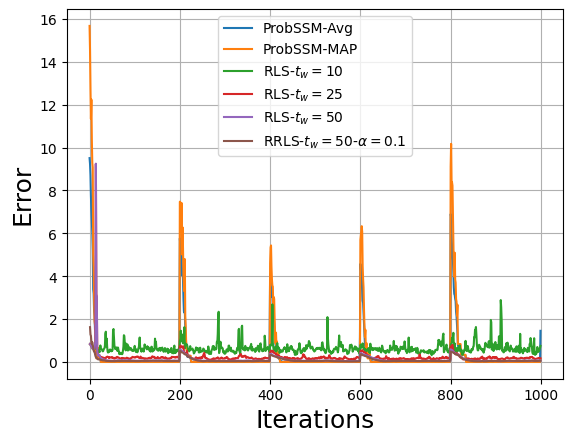

In [19]:
for exp in EXPS:
    x_ax = np.arange(1, T) if 'rls' in exp['method'] else np.arange(T)
    plt.plot(x_ax, errs[exp['leg']], label=exp['leg'])

plt.grid()
plt.xlabel("Iterations", fontsize=18)
plt.ylabel("Error", fontsize=18)
plt.legend()

plt.savefig('results/synth_data/err.pdf')

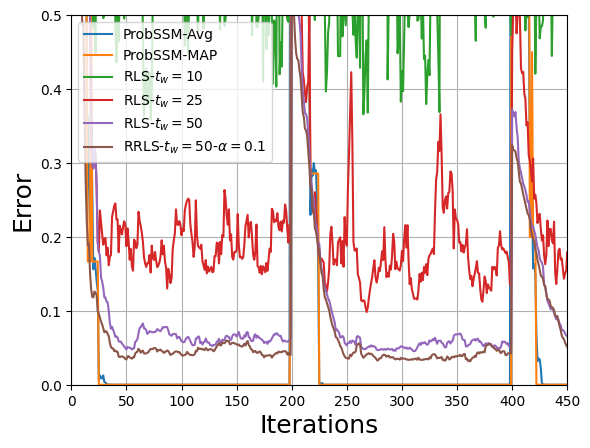

In [20]:
for exp in EXPS:
    x_ax = np.arange(1, T) if 'rls' in exp['method'] else np.arange(T)
    plt.plot(x_ax, errs[exp['leg']], label=exp['leg'])

plt.grid()
plt.xlabel("Iterations", fontsize=18)
plt.ylabel("Error", fontsize=18)
plt.legend()

plt.ylim([0,0.5])
plt.xlim(0,450)

plt.savefig('results/synth_data/zoomed.pdf')

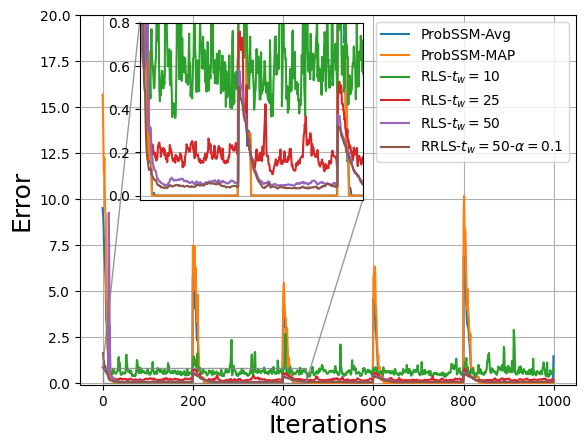

In [21]:
fig, ax = plt.subplots()
axins = ax.inset_axes([0.12, 0.5, 0.45, 0.48])
for exp in EXPS:
    x_ax = np.arange(1, T) if 'rls' in exp['method'] else np.arange(T)
    ax.plot(x_ax, errs[exp['leg']], label=exp['leg'])

    axins.plot(x_ax, errs[exp['leg']])

axins.set_xlim(0,450)
axins.set_ylim(-0.02,0.8)
axins.set_xticks([])  # Remove x-axis ticks
#axins.set_yticks([])  # Remove y-axis ticks

axins.grid()

# Add a rectangle to indicate the zoomed region
ax.indicate_inset_zoom(axins, alpha=0.8)

ax.set_ylim(-0.1,20)

ax.grid()
plt.xlabel("Iterations", fontsize=18)
plt.ylabel("Error", fontsize=18)
plt.legend()

plt.savefig('results/synth_data/err_with_zoom.pdf')

In [23]:
B_transition.nbytes / (1024**3)

0.5

In [24]:
B_transition.shape

(8192, 8192)